In [2]:
import glob, os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from scipy import stats
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

In [2]:
path = '../Results/Detection_fishcall/manual_csv_0.75'

In [275]:
alldf = pd.DataFrame()

for csvpath in glob.glob(f'{path}/202308/*_classify.csv'):
    print(csvpath)
    df = pd.read_csv(csvpath)
    df = df[df['keep']==True]
    alldf = pd.concat([alldf, df])

../Results/Detection_fishcall/manual_csv_0.75/202308/result_230819_stats_classify.csv
../Results/Detection_fishcall/manual_csv_0.75/202308/result_230820_stats_classify.csv
../Results/Detection_fishcall/manual_csv_0.75/202308/result_230830_stats_classify.csv
../Results/Detection_fishcall/manual_csv_0.75/202308/result_230818_stats_classify.csv


In [276]:
TYPE = 'A'
alldf_A = alldf[alldf['classify']==TYPE]

In [277]:
newdf = {'time':[],
         'SPL':[],
         'Peak_f':[],
        'pulse':[],
        'pulse_interval':[],
        'call_duration':[]
        }

for i in range(len(alldf_A)):
    begintmp = re.split('[(|)|,]',alldf_A['time_min_date'].values[i])
    begin = datetime(int(begintmp[1]),int(begintmp[2]),int(begintmp[3]),int(begintmp[4]),int(begintmp[5]),int(begintmp[6]),int(begintmp[7]))
    method = alldf_A['peak_method'].values[i]
    peak_f = alldf_A['Peak_f'].values[i]
    SPL = alldf_A['SPLrms'].values[i]
    if method == 'corr':
        pulse = alldf_A['corr_pulse'].values[i]
        pulse_interval = alldf_A['corr_pulse_interval'].values[i]
        call_duration = alldf_A['corr_call_duration'].values[i]
    elif method == 'waveform':
        pulse = alldf_A['pulse'].values[i]
        pulse_interval = alldf_A['pulse_interval'].values[i]
        call_duration = alldf_A['call_duration'].values[i]  
    
    newdf['time'].append(begin)
    newdf['Peak_f'].append(peak_f)
    newdf['SPL'].append(SPL)
    newdf['pulse'].append(pulse)
    newdf['pulse_interval'].append(pulse_interval)
    newdf['call_duration'].append(call_duration)
    
newdf = pd.DataFrame(newdf)


Text(0.5, 0.98, 'Type A / N=9')

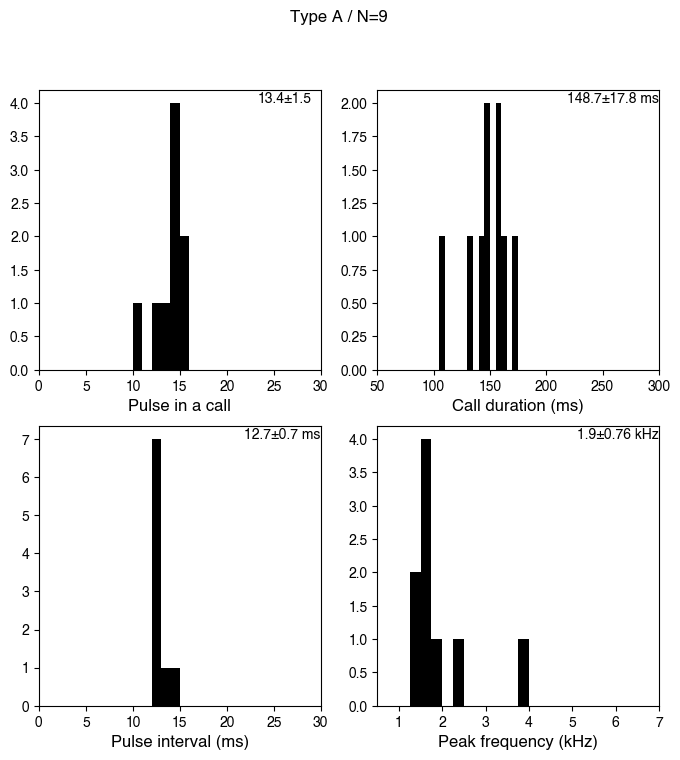

In [278]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
plt.rc('font', family='Helvetica')

bins = np.arange(50, 300+1, 5)
tmp = ax[0,1].hist(np.array(newdf['call_duration'])*1000, bins=bins, color='k')
cnt=tmp[0]; interval=tmp[-1]
ax[0,1].set_xlim(50, 300)
ax[0,1].set_xlabel('Call duration (ms)', fontsize=12)
avg = round(np.nanmean(np.array(newdf['call_duration'])*1000), 1)
std = round(np.nanstd(np.array(newdf['call_duration'])*1000),1)
ax[0,1].text(x=bins[-1], y = max(cnt),s = f'{avg}±{std} ms', ha='right')

bins = np.arange(0, 30, 1)
tmp = ax[0,0].hist(newdf['pulse'], bins=bins, color='k')
cnt=tmp[0]; interval=tmp[-1]
ax[0,0].set_xlim(0, 30)
ax[0,0].set_xlabel('Pulse in a call', fontsize=12)
avg = round(np.nanmean(newdf['pulse']),1)
std = round(np.nanstd(newdf['pulse']),1)
ax[0,0].text(x=bins[-1], y = max(cnt),s = f'{avg}±{std}', ha='right')

bins = np.arange(0, 30+1, 1)
tmp=ax[1,0].hist(np.array(newdf['pulse_interval'])*1000, bins=bins, color='k')
cnt=tmp[0]; interval=tmp[-1]
ax[1,0].set_xlabel('Pulse interval (ms)', fontsize=12)
ax[1,0].set_xlim(0, 30)
avg = round(np.nanmean(np.array(newdf['pulse_interval'])*1000),1)
std = round(np.nanstd(np.array(newdf['pulse_interval'])*1000),1)
ax[1,0].text(x=bins[-1], y = max(cnt),s = f'{avg}±{std} ms', ha='right')

bins = np.arange(0.5, 7+1, 0.25)
tmp= ax[1,1].hist(np.array(newdf['Peak_f'])/1000, bins=bins, color='k')
cnt=tmp[0]; interval=tmp[-1]
ax[1,1].set_xlim(0.5,7)
ax[1,1].set_xlabel('Peak frequency (kHz)', fontsize=12)
ax[1,1].set_xticks(np.arange(1,7+1,1))
avg = round(np.nanmean(np.array(newdf['Peak_f'])/1000),2)
std = round(np.nanstd(np.array(newdf['Peak_f'])/1000),2)
ax[1,1].text(x=7, y = max(cnt), s = f'{avg}±{std} kHz', ha='right')

plt.suptitle(f'Type {TYPE} / N={len(newdf)}')


# plt.savefig('../Results/Detection_fishcall/features_calls_202308.png',dpi=300, bbox_inches='tight')
# plt.savefig('../Results/Detection_fishcall/features_calls_202308.pdf',dpi=300, bbox_inches='tight')

/var/folders/07/_m900g1931d1pc5dgv3v4qpw0000gn/T/ipykernel_58407/1913694295.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = merged_data.pivot('date', 'hour', 'count').fillna(0)


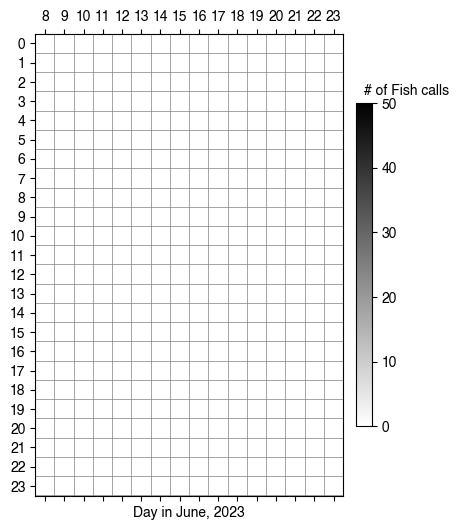

In [282]:
newdf['timestamp'] = pd.to_datetime(newdf['time'])
newdf['date'] = newdf['timestamp'].dt.date
newdf['hour'] = newdf['timestamp'].dt.hour

# 生成一个包含从 2023-06-08 开始的所有日期和小时的完整 DataFrame
start_date = pd.to_datetime('2023-06-08').date()
end_date = datetime(2023,6,23)#alldf['date'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
all_hours = pd.DataFrame([(date, hour) for date in all_dates for hour in range(24)], columns=['date', 'hour'])

# 合并数据，缺失值填充为 0
merged_data = pd.merge(all_hours, newdf.groupby(['date', 'hour']).size().reset_index(name='count'), how='left', on=['date', 'hour'])
merged_data['count'] = merged_data['count'].fillna(0)

# 构建透视表用于热力图
heatmap_data = merged_data.pivot('date', 'hour', 'count').fillna(0)

# 转换成 numpy array 以便于绘图
heatmap_matrix = heatmap_data.to_numpy()

# 绘制 heatmap
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(heatmap_matrix.T, cmap='gray_r', vmin=0, vmax=50)
cbar = fig.colorbar(cax, ax=ax, pad=0.02, shrink=0.7)
cbar.ax.set_title('# of Fish calls', ha='left', fontsize=10)

# 设置 x 轴 和 y 轴 的刻度和标签
ax.set_xticks(np.arange(len(heatmap_data.index)))
ax.set_yticks(np.arange(len(heatmap_data.columns)))
ax.set_yticklabels(heatmap_data.columns)
ax.set_xticklabels([date.day for date in heatmap_data.index], rotation=90)

# 设置标签
plt.xlabel('Day in June, 2023')

# 显示数值
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        if int(heatmap_matrix[i, j]) > 0:
            if int(heatmap_matrix[i, j]) > 30:
                color = 'white'
            else:
                color = 'black'
            plt.text(i, j, int(heatmap_matrix[i, j]), ha='center', va='center', color=color, fontsize=7)
        
# 添加网格线

ax.set_yticks(np.arange(-0.51, len(heatmap_data.columns), 1), minor=True)
ax.set_xticks(np.arange(-0.51, len(heatmap_data.index), 1), minor=True)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=0, )
ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', size=0)



# plt.savefig('../Results/Detection_fishcall/heatmap/Taoyuan_heatmap_202306.png', dpi=300, bbox_inches='tight')
# plt.savefig('../Results/Detection_fishcall/heatmap/Taoyuan_heatmap_202306.pdf', dpi=300, bbox_inches='tight')

In [283]:
newdf = {'time':[],
         'timehour':[],
         'SPL':[],
         'Peak_f':[],
        'pulse':[],
        'pulse_interval':[],
        'call_duration':[],
         'classify':[]
        }
for i in range(len(alldf)):
    TYPE = alldf['classify'].values[i]
    if type(TYPE) == str:
        begintmp = re.split('[(|)|,]',alldf['time_min_date'].values[i])
        begin = datetime(int(begintmp[1]),int(begintmp[2]),int(begintmp[3]),int(begintmp[4]),int(begintmp[5]),int(begintmp[6]),int(begintmp[7]))
        method = alldf['peak_method'].values[i]
        peak_f = alldf['Peak_f'].values[i]
        SPL = alldf['SPLrms'].values[i]
        if method == 'corr':
            pulse = alldf['corr_pulse'].values[i]
            pulse_interval = alldf['corr_pulse_interval'].values[i]
            call_duration = alldf['corr_call_duration'].values[i]
        elif method == 'waveform':
            pulse = alldf['pulse'].values[i]
            pulse_interval = alldf['pulse_interval'].values[i]
            call_duration = alldf['call_duration'].values[i]  

        newdf['time'].append(begin)
        newdf['timehour'].append(datetime(begin.year,begin.month,begin.day,begin.hour,0,0))
        newdf['Peak_f'].append(peak_f)
        newdf['SPL'].append(SPL)
        newdf['pulse'].append(pulse)
        newdf['pulse_interval'].append(pulse_interval*1000)
        newdf['call_duration'].append(call_duration*1000)
        newdf['classify'].append(TYPE)
        
newdf = pd.DataFrame(newdf)

/var/folders/07/_m900g1931d1pc5dgv3v4qpw0000gn/T/ipykernel_58407/1743328223.py:18: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = merged_data.pivot('date', 'hour', 'count').fillna(0)


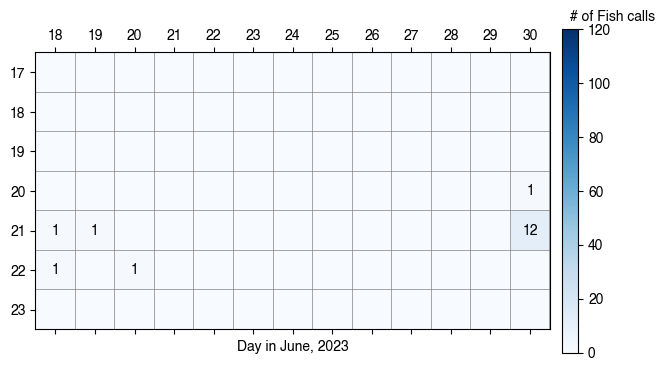

In [284]:
# 解析時間戳
newdf['timestamp'] = pd.to_datetime(newdf['time'])
newdf['date'] = newdf['timestamp'].dt.date
newdf['hour'] = newdf['timestamp'].dt.hour

start_date = newdf['date'].min()#pd.to_datetime('2023-06-18').date()
end_date = newdf['date'].max()#datetime(2023,6,23)#alldf['date'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
all_hours = pd.DataFrame([(date, hour) for date in all_dates for hour in range(17, 24)], columns=['date', 'hour'])

tempdf = newdf#[newdf['classify']=='A']
# 合并数据，缺失值填充为 0
merged_data = pd.merge(all_hours, tempdf.groupby(['date', 'hour']).size().reset_index(name='count'), how='left', on=['date', 'hour'])
merged_data['SPL'] = merged_data['count'].fillna(0)

# 构建透视表用于热力图
# heatmap_data = merged_data.pivot_table(columns='date', index='hour', values='SPL', aggfunc='mean')
heatmap_data = merged_data.pivot('date', 'hour', 'count').fillna(0)

# 转换成 numpy array 以便于绘图
heatmap_matrix = heatmap_data.to_numpy()

# 绘制 heatmap
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(heatmap_matrix.T, cmap='Blues', vmin=0, vmax=120)
cbar = fig.colorbar(cax, ax=ax, pad=0.02, shrink=0.7)
cbar.ax.set_title('# of Fish calls', ha='left', fontsize=10)

# 设置 x 轴 和 y 轴 的刻度和标签
ax.set_xticks(np.arange(len(heatmap_data.index)))
ax.set_yticks(np.arange(len(heatmap_data.columns)))
ax.set_yticklabels(heatmap_data.columns)
ax.set_xticklabels([date.day for date in heatmap_data.index], rotation=90)

# 设置标签
plt.xlabel('Day in June, 2023')

# 显示数值
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        if int(heatmap_matrix[i, j]) > 0:
            if int(heatmap_matrix[i, j]) > 30:
                color = 'white'
            else:
                color = 'black'
            plt.text(i, j, int(heatmap_matrix[i, j]), ha='center', va='center', color=color, fontsize=10)
        
# 添加网格线

ax.set_yticks(np.arange(-0.51, len(heatmap_data.columns), 1), minor=True)
ax.set_xticks(np.arange(-0.51, len(heatmap_data.index), 1), minor=True)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=0, )
ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', size=0)



In [13]:
# 解析時間戳
newdf['timestamp'] = pd.to_datetime(newdf['time'])
newdf['date'] = newdf['timestamp'].dt.date
newdf['hour'] = newdf['timestamp'].dt.hour

start_date = newdf['date'].min()#pd.to_datetime('2023-06-18').date()
end_date = newdf['date'].max()#datetime(2023,6,23)#alldf['date'].max()
all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
all_hours = pd.DataFrame([(date, hour) for date in all_dates for hour in range(17, 24)], columns=['date', 'hour'])


TYPE='B'
if TYPE== 'A':
    cmp = 'Blues'
elif TYPE== 'B':
    cmp = 'Oranges'
elif TYPE== 'C':
    cmp = 'Purples'
tempdf = newdf#[newdf['classify']==TYPE]

heatmap_data = tempdf.pivot_table(columns='hour', index='date', values='call_duration', aggfunc='mean')
# heatmap_data = merged_data.pivot('date', 'hour', 'SPL').fillna(0)
# 构建透视表用于热力图
# heatmap_data = merged_data.pivot_table(columns='date', index='hour', values='SPL', aggfunc='mean')
# heatmap_data = merged_data.pivot('date', 'hour', 'count').fillna(0)

# 转换成 numpy array 以便于绘图
heatmap_matrix = heatmap_data.to_numpy()

# 绘制 heatmap
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(heatmap_matrix.T, cmap=cmp, vmin=130, vmax=150)
cbar = fig.colorbar(cax, ax=ax, pad=0.02, shrink=0.7)
cbar.ax.set_title('call_duration (ms)', ha='left', fontsize=10)

# 设置 x 轴 和 y 轴 的刻度和标签
ax.set_xticks(np.arange(len(heatmap_data.index)))
ax.set_yticks(np.arange(len(heatmap_data.columns)))
ax.set_yticklabels(heatmap_data.columns)
ax.set_xticklabels([date.day for date in heatmap_data.index], rotation=90)
plt.xlabel('Day in June, 2023')

for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        if not np.isnan(heatmap_matrix[i, j]):
            if int(heatmap_matrix[i, j]) > 0 :
                if float(heatmap_matrix[i, j]) > 140:
                    color = 'white'
                else:
                    color = 'black'
                plt.text(i, j, round(heatmap_matrix[i, j],1), ha='center', va='center', color=color, fontsize=10)
        
# 添加网格线

ax.set_yticks(np.arange(-0.51, len(heatmap_data.columns), 1), minor=True)
ax.set_xticks(np.arange(-0.51, len(heatmap_data.index), 1), minor=True)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=0, )
ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', size=0)


NameError: name 'newdf' is not defined

In [3]:
tempdf = pd.read_excel('../DataBase/Temperature/Taoyuan/230608-230626.xlsx')
time = pd.to_datetime(tempdf['日期—時間 (Taiwan Standard Time)'])
temp = tempdf['Ch: 1 - 溫度   (°C)']
newdf = pd.DataFrame({'time':time, 
                     'dtt': temp-np.mean(temp)})

In [13]:
heatmap_data.index[:16]

Index([2023-06-08, 2023-06-09, 2023-06-10, 2023-06-11, 2023-06-12, 2023-06-13,
       2023-06-14, 2023-06-15, 2023-06-16, 2023-06-17, 2023-06-18, 2023-06-19,
       2023-06-20, 2023-06-21, 2023-06-22, 2023-06-23],
      dtype='object', name='date')

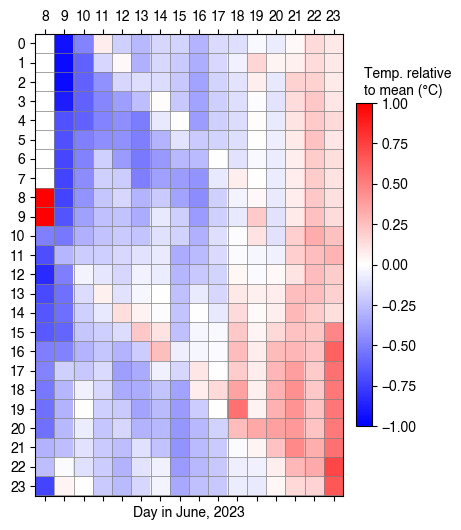

In [15]:
newdf['timestamp'] = pd.to_datetime(newdf['time'])
newdf['date'] = newdf['timestamp'].dt.date
newdf['hour'] = newdf['timestamp'].dt.hour

heatmap_data = newdf.pivot_table(columns='hour', index='date', values='dtt', aggfunc='mean')
heatmap_matrix = heatmap_data.to_numpy()[:16,:]


# 绘制 heatmap
plt.rcParams["font.family"] = "Helvetica"
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.matshow(heatmap_matrix.T, cmap='bwr', vmin=-1, vmax=1)
cbar = fig.colorbar(cax, ax=ax, pad=0.02, shrink=0.7)
cbar.ax.set_title('Temp. relative\nto mean (°C)', ha='left', fontsize=10)

# 设置 x 轴 和 y 轴 的刻度和标签
ax.set_xticks(np.arange(0,16))#len(heatmap_data.index)))
ax.set_yticks(np.arange(len(heatmap_data.columns)))
ax.set_yticklabels(heatmap_data.columns)
ax.set_xticklabels([date.day for date in heatmap_data.index[:16]], rotation=90)
plt.xlabel('Day in June, 2023')

# for i in range(len(heatmap_data.index)):
#     for j in range(len(heatmap_data.columns)):
#         if not np.isnan(heatmap_matrix[i, j]):
#             if int(heatmap_matrix[i, j]) > 0 :
#                 if float(heatmap_matrix[i, j]) > 140:
#                     color = 'white'
#                 else:
#                     color = 'black'
#                 plt.text(i, j, round(heatmap_matrix[i, j],1), ha='center', va='center', color=color, fontsize=10)
        
# 添加网格线

ax.set_yticks(np.arange(-0.51, len(heatmap_data.columns), 1), minor=True)
ax.set_xticks(np.arange(-0.51, len(heatmap_data.index)-3, 1), minor=True)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=0, )
ax.grid(which='minor', color='grey', linestyle='-', linewidth=0.5)
ax.tick_params(which='minor', size=0)
